<a href="https://colab.research.google.com/github/glitch-y/CE888-Project/blob/main/2.%20Scripts/3.%20Preprocessing_Offensive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install contractions
!pip install emot

     |████████████████████████████████| 327kB 5.5MB/s 
     |████████████████████████████████| 266kB 41.9MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.1-cp37-cp37m-linux_x86_64.whl size=85247 sha256=99148af9a3a93ec981974c07c168b627f8ac995c3e69b5f8f962a16e23bfb240
  Stored in directory: /root/.cache/pip/wheels/e4/ab/f7/cb39270df8f6126f3dd4c33d302357167086db460968cfc80c
Successfully built pyahocorasick


# Import Modules
Import modules for preprocessing

In [2]:
#Import modules
import html #import 'html' module to clean html elements such as '&amp;, &lt' etc.
import numpy as np
import pandas as pd
import contractions #import 'contractions' module to expand linguistic contactions (e.g. it's = it is)
from emot import UNICODE_EMO #import emoji dictionary to transform emojis into text
import re
import seaborn as sns

# Import Data
Import data from TweetEval Github

In [3]:
#Import files for the 'offensive' task
data_offensive_test = pd.read_csv(f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/offensive/test_text.txt", 
                                delimiter='\t', dtype=str, header= None)
data_offensive_test_labels = pd.read_csv(f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/offensive/test_labels.txt", 
                                      delimiter='\t', dtype=str, header= None)
data_offensive_mapping = pd.read_csv(f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/offensive/mapping.txt", 
                                      delimiter='\t', dtype=str, header= None)
data_offensive_train = pd.read_csv(f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/offensive/train_text.txt", 
                                      delimiter='\t', dtype=str, header= None)
data_offensive_train_labels = pd.read_csv(f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/offensive/train_labels.txt", 
                                      delimiter='\t', dtype=str, header= None)
data_offensive_val = pd.read_csv(f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/offensive/val_text.txt", 
                                      delimiter='\t', dtype=str, header= None)
data_offensive_val_labels = pd.read_csv(f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/offensive/val_labels.txt", 
                                      delimiter='\t', dtype=str, header= None)

#Assign column names for offensive datasets
data_offensive_test.columns =['content']
data_offensive_test_labels.columns =['labels']
data_offensive_mapping.columns =['labels','mapping']
data_offensive_train.columns =['content']
data_offensive_train_labels.columns =['labels']
data_offensive_val.columns =['content']
data_offensive_val_labels.columns =['labels'] 

# Preprocessing

##Replace misspelled words

Typos are common in text data and the scripts below create a dictionary of commonly mispelled words and applies it against the 3 'text' sets

In [4]:
#Import misspelling data as dictionary
misspell_data = pd.read_csv("https://raw.githubusercontent.com/glitch-y/CE888-Project/main/1.%20Dictionaries/Misspelling.txt",sep=":",names=["correction","misspell"])
misspell_data.misspell = misspell_data.misspell.str.strip()
misspell_data.misspell = misspell_data.misspell.str.split(" ")
misspell_data = misspell_data.explode("misspell").reset_index(drop=True)
misspell_data.drop_duplicates("misspell",inplace=True)
miss_corr = dict(zip(misspell_data.misspell, misspell_data.correction))

#Preview misspelling dictionary
{v:miss_corr[v] for v in [list(miss_corr.keys())[k] for k in range(10)]}

{'Steffen': 'Stephen',
 'abilitey': 'ability',
 'abouy': 'about',
 'absorbtion': 'absorption',
 'accidently': 'accidentally',
 'bout': 'about',
 'nevade': 'Nevada',
 'presbyterian': 'Presbyterian',
 'rsx': 'RSX',
 'susan': 'Susan'}

In [5]:
#Create misspelling correction function
def misspelled_correction(x):
    for i in x.split(): 
        if i in miss_corr.keys(): 
            x = x.replace(i, miss_corr[i]) 
    return x

#Apply misspelling correction to text dataframes as new column
data_offensive_test['content_clean'] = data_offensive_test.content.apply(lambda x : misspelled_correction(x).lower())
data_offensive_train['content_clean'] = data_offensive_train.content.apply(lambda x : misspelled_correction(x).lower())
data_offensive_val['content_clean'] = data_offensive_val.content.apply(lambda x : misspelled_correction(x).lower())

##Replace abbreviated words

Social media users normally use abbreviated text due to the fast nature of writing a post as well as certain limitations in terms of characters (a well-known aspect of Twitter. 

The script below create a dictionary of commonly known internet abbreviations and applies it against the 3 'text' data sets.

In [6]:
#Abbreviated chat words conversion
#Create Dictionary
chat_dictionary = pd.read_csv("https://raw.githubusercontent.com/glitch-y/CE888-Project/main/1.%20Dictionaries/SlangDictionary.csv",dtype=str, names=["Slang", "Translation"])
chat_dictionary=chat_dictionary.apply(lambda x: x.str.lower())
slang_corr = dict(zip(chat_dictionary.Slang, chat_dictionary.Translation))

#Preview abbreviation dictionary
{v:slang_corr[v] for v in [list(slang_corr.keys())[k] for k in range(10)]}

{'a.s.a.p.': 'as soon as possible',
 'af': 'as fuck',
 'ama': 'ask me anything',
 'asap': 'as soon as possible',
 'atk': 'at the keyboard',
 'atm': 'at the moment',
 'bbl': 'be back later',
 'bcs': 'because',
 'bcus': 'because',
 'bcuz': 'because'}

In [7]:
#Create abbreviation replacement function
def abbrev_replace(x):
    for i in x.split(): 
        if i in slang_corr.keys(): 
            x = x.replace(i, slang_corr[i]) 
    return x

#Apply misspelling correction to dataframe as new column
data_offensive_test.content_clean = data_offensive_test.content_clean.apply(lambda x : abbrev_replace(x))
data_offensive_train.content_clean = data_offensive_train.content_clean.apply(lambda x : abbrev_replace(x))
data_offensive_val.content_clean = data_offensive_val.content_clean.apply(lambda x : abbrev_replace(x))

#Check
data_offensive_train.head()

,content,content_clean
0,@user Bono... who cares. Soon people will unde...,@user bono... who cares. soon people will unde...
1,@user Eight years the republicans denied obama...,@user eight years the republicans denied obama...
2,@user Get him some line help. He is gonna be j...,@user get him some line help. he is gonna be j...
3,@user @user She is great. Hi Fiona!,@user @user she is great. hi fiona!
4,@user She has become a parody unto herself? Sh...,@user she has become a parody unto herself? sh...


##Remove HTML elements

Data scraped from various websites usually returns certain html elements such as '&amp;' for '&'

The script below uses the 'html' module to clean the data of any such occurences

In [8]:
#clean HTML charachters such as &amp;, &lt; etc using 'html' module
data_offensive_test.content_clean = data_offensive_test.content_clean.apply(lambda x: html.unescape(x))
data_offensive_train.content_clean = data_offensive_train.content_clean.apply(lambda x: html.unescape(x))
data_offensive_val.content_clean = data_offensive_val.content_clean.apply(lambda x: html.unescape(x))

##Fix language contractions

The script below uses the 'contractions' module to expand any language contractions such as 'let's' into 'let us' or 'it's' into 'it is'

In [9]:
#fix contractions; i.e. 'It's' transforms into 'it is'
data_offensive_test.content_clean = data_offensive_test.content_clean.apply(lambda x: contractions.fix(x))
data_offensive_train.content_clean = data_offensive_train.content_clean.apply(lambda x: contractions.fix(x))
data_offensive_val.content_clean = data_offensive_val.content_clean.apply(lambda x: contractions.fix(x))

##Remove 'newlines' and replace '&' with 'and'


In [10]:
#Remove newlines from data and replace '&' with 'and'
data_offensive_test.content_clean = data_offensive_test.content_clean.replace(r'\\n',' ', regex=True)
data_offensive_test.content_clean = data_offensive_test.content_clean.replace(r'&','and', regex=True)

data_offensive_train.content_clean = data_offensive_train.content_clean.replace(r'\\n',' ', regex=True)
data_offensive_train.content_clean = data_offensive_train.content_clean.replace(r'&','and', regex=True)

data_offensive_val.content_clean = data_offensive_val.content_clean.replace(r'\\n',' ', regex=True)
data_offensive_val.content_clean = data_offensive_val.content_clean.replace(r'&','and', regex=True)

##Convert emojis into text

Emoji's describe a variety of offensives or objects which can help increase the accuracy of the algorithm. 

The script below uses the 'emot' module to lookup emoji's in the module dictionary and translate them into text.


In [11]:
#convert emojis into text
def convert_emojis(x):
    for emot in UNICODE_EMO:
        x = x.replace(emot, "_".join(UNICODE_EMO[emot].replace(",","").replace(":","").split()))
    return x

data_offensive_test.content_clean = data_offensive_test.content_clean.apply(lambda x: convert_emojis(x))
data_offensive_train.content_clean = data_offensive_train.content_clean.apply(lambda x: convert_emojis(x))
data_offensive_val.content_clean = data_offensive_val.content_clean.apply(lambda x: convert_emojis(x))

##Remove unnecessary punctuation

Certain types of punctuation is not of particular use and is removed using the script below. 

However, commas, periods, exclamation marks, question marks apostrophes have not been taken out as they help set the tone or define the relationships between words.


In [12]:
#Remove unnecessary punctuation
def punctuation(x): 
  
    punctuations = '()-[]{};:\<>/#$%^&_~'
  
    for i in x.lower(): 
        if i in punctuations: 
            x = x.replace(i, " ") 
    return x

data_offensive_test.content_clean = data_offensive_test.content_clean.apply(lambda x: punctuation(x))
data_offensive_train.content_clean = data_offensive_train.content_clean.apply(lambda x: punctuation(x))
data_offensive_val.content_clean = data_offensive_val.content_clean.apply(lambda x: punctuation(x))

##Remove '@user' mentions


In [13]:
#Remove @user mentions
data_offensive_test.content_clean = data_offensive_test.content_clean.str.replace('@user','')
data_offensive_train.content_clean = data_offensive_train.content_clean.str.replace('@user','')
data_offensive_val.content_clean = data_offensive_val.content_clean.str.replace('@user','')


data_offensive_test.head()

,content,content_clean
0,#ibelieveblaseyford is liar she is fat ugly li...,ibelieveblaseyford is liar she is fat ugly li...
1,@user @user @user I got in a pretty deep debat...,i got in a pretty deep debate with my frien...
2,"...if you want more shootings and more death, ...","...if you want more shootings and more death, ..."
3,Angels now have 6 runs. Five of them have come...,angels now have 6 runs. five of them have come...
4,#Travel #Movies and Unix #Fortune combined Vi...,travel movies and unix fortune combined vi...


##Assign labels to Tweet datasets

The script below assigns the labels to the 3 separate 'text' files.

In [14]:
#Test Data
data_offensive_test.reset_index(inplace=True)
data_offensive_test_labels.reset_index(inplace=True)
processed_offensive_test=data_offensive_test.merge(data_offensive_test_labels)

#Train Data
data_offensive_train.reset_index(inplace=True)
data_offensive_train_labels.reset_index(inplace=True)
processed_offensive_train=data_offensive_train.merge(data_offensive_train_labels)

#Val Data
data_offensive_val.reset_index(inplace=True)
data_offensive_val_labels.reset_index(inplace=True)
processed_offensive_val=data_offensive_val.merge(data_offensive_val_labels)

##Map labels
Map each row with the respective offensive tags, based on the values in column 'Labels'


In [15]:
#offensive test data mapping
mapped_offensive_test=processed_offensive_test[['labels','content_clean']].merge(data_offensive_mapping,how='left')

#Check
print(mapped_offensive_test)

    labels                                      content_clean        mapping
0        1   ibelieveblaseyford is liar she is fat ugly li...      offensive
1        0     i got in a pretty deep debate with my frien...  not-offensive
2        0  ...if you want more shootings and more death, ...  not-offensive
3        0  angels now have 6 runs. five of them have come...  not-offensive
4        0   travel  movies and unix  fortune combined  vi...  not-offensive
..     ...                                                ...            ...
855      0   cnn irrationally argues 4 legalising  abortio...  not-offensive
856      0                city of chicago, democrat run wi...  not-offensive
857      1   conservatives do not care what you post..it i...      offensive
858      0   antifa  resist.. trump is trying to bring wor...  not-offensive
859      0   maine you need to face facts  does not really...  not-offensive

[860 rows x 3 columns]


In [16]:
#offensive train data mapping
mapped_offensive_train=processed_offensive_train[['labels','content_clean']].merge(data_offensive_mapping,how='left')

#Check
print(mapped_offensive_train)

      labels                                      content_clean        mapping
0          0   bono... who cares. soon people will understan...  not-offensive
1          1   eight years the republicans denied obama’s pi...      offensive
2          0   get him some line help. he is going to be jus...  not-offensive
3          0                           she is great. hi fiona!   not-offensive
4          1   she has become a parody unto herself? she has...      offensive
...      ...                                                ...            ...
11911      1         i wonder if they are sex traffic victims?       offensive
11912      0        do we dare say he is... better than nyjer?   not-offensive
11913      0                          no idea who he is. sorry   not-offensive
11914      0   professor who shot self over trump says gun c...  not-offensive
11915      1     here your proof!  our african 🇺🇸 friends do...      offensive

[11916 rows x 3 columns]


In [17]:
#offensive val data mapping
mapped_offensive_val=processed_offensive_val[['labels','content_clean']].merge(data_offensive_mapping,how='left')

#Check
print(mapped_offensive_val)

     labels                                      content_clean        mapping
0         0                  wiiu is not even a real console.   not-offensive
1         1     if he is from az i would put my money on se...      offensive
2         0   i thought canada had strict gun control.  hel...  not-offensive
3         0                  following all  maga patriots p...  not-offensive
4         0               1 minute of truth  gun control via    not-offensive
...     ...                                                ...            ...
1319      0    whose twitter interest start with food  is h...  not-offensive
1320      0    how did the press"" get the letter????? maga""   not-offensive
1321      0        sorry about your son. i am sure he would...  not-offensive
1322      1                              fuck alan I am sorry       offensive
1323      0   tories  labour  ge2017  conservatives conserv...  not-offensive

[1324 rows x 3 columns]


#Data Exploration

not-offensive    620
offensive        240
Name: mapping, dtype: int64


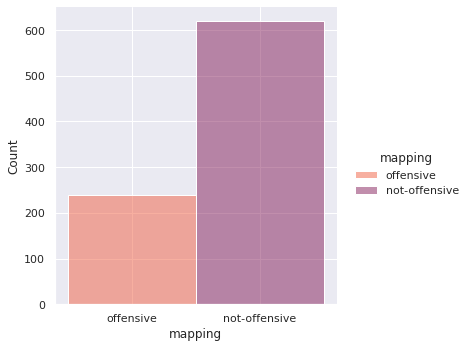

In [18]:
#Exploration of 'offensive Test Data'
sns.set_theme(style="darkgrid")
sns.displot(mapped_offensive_test, x='mapping', hue='mapping',palette='rocket_r')
print(mapped_offensive_test.mapping.value_counts())

not-offensive    7975
offensive        3941
Name: mapping, dtype: int64


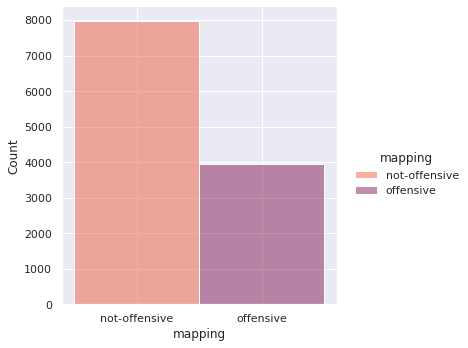

In [19]:
#Exploration of 'offensive Train Data'
sns.set_theme(style="darkgrid")
sns.displot(mapped_offensive_train, x='mapping', hue='mapping', palette='rocket_r')
print(mapped_offensive_train.mapping.value_counts())

not-offensive    865
offensive        459
Name: mapping, dtype: int64


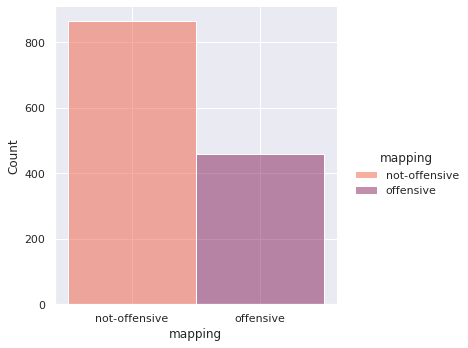

In [20]:
#Exploration of 'offensive Val Data'
sns.set_theme(style="darkgrid")
sns.displot(mapped_offensive_val, x='mapping', hue='mapping', palette='rocket_r')
print(mapped_offensive_val.mapping.value_counts())

In [22]:
mapped_offensive_test.to_csv("mapped_offensive_test")
mapped_offensive_train.to_csv("mapped_offensive_train")
mapped_offensive_val.to_csv("mapped_offensive_val")